**<h2>Quick Start: Unlearnable Examples</h2>**

This quickstart notebook was taken from https://github.com/HanxunH/Unlearnable-Examples. It was modified to test adding sample-wise error-minimizing noise in the MNIST dataset. 

<h3>Prepare Data</h3>

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Prepare Dataset
train_transform = [
    transforms.ToTensor()
]
test_transform = [
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
test_transform = transforms.Compose(test_transform)

clean_train_dataset = datasets.MNIST(root='../datasets', train=True, download=True, transform=train_transform)
clean_test_dataset = datasets.MNIST(root='../datasets', train=False, download=True, transform=test_transform)
test = datasets.CIFAR10(root='../datasets', train=True, download=True, transform=train_transform)
clean_train_loader = DataLoader(dataset=clean_train_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=4)
clean_test_loader = DataLoader(dataset=clean_test_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=4)

Files already downloaded and verified


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/Unlearnable-Examples/')

In [4]:
clean_train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

<h3>Prepare Model</h3>

In [5]:
from ResNet import ResNet18
import toolbox

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

base_model = ResNet18()
base_model = base_model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)

noise_generator = toolbox.PerturbationTool(epsilon=0.03137254901960784, num_steps=20, step_size=0.0031372549019607846)

Using modified ResNet18


<h3>Generate Error-Minimizing Noise</h3>

In [ ]:
from tqdm import tqdm

noise = torch.zeros([60000, 1, 28, 28])
data_iter = iter(clean_train_loader)
condition = True
train_idx = 0

while condition:
    # optimize theta for M steps
    base_model.train()
    for param in base_model.parameters():
        param.requires_grad = True
    for j in range(0, 10):
        try:
            (images, labels) = next(data_iter)
        except:
            train_idx = 0
            data_iter = iter(clean_train_loader)
            (images, labels) = next(data_iter)
        
        for i, _ in enumerate(images):
            # Update noise to images
            images[i] += noise[train_idx]
            train_idx += 1
        images, labels = images.cuda(), labels.cuda()
        base_model.zero_grad()
        optimizer.zero_grad()
        logits = base_model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(base_model.parameters(), 5.0)
        optimizer.step()
    
    # Perturbation over entire dataset
    idx = 0
    for param in base_model.parameters():
        param.requires_grad = False
    for i, (images, labels) in tqdm(enumerate(clean_train_loader), total=len(clean_train_loader)):
        batch_start_idx, batch_noise = idx, []
        for i, _ in enumerate(images):
            # Update noise to images
            batch_noise.append(noise[idx])
            idx += 1
        batch_noise = torch.stack(batch_noise).cuda()
        
        # Update sample-wise perturbation
        base_model.eval()
        images, labels = images.cuda(), labels.cuda()
        perturb_img, eta = noise_generator.min_min_attack(images, labels, base_model, optimizer, criterion, 
                                                          random_noise=batch_noise)
        for i, delta in enumerate(eta):
            noise[batch_start_idx+i] = delta.clone().detach().cpu()
        
    # Eval stop condition
    eval_idx, total, correct = 0, 0, 0
    for i, (images, labels) in enumerate(clean_train_loader):
        for i, _ in enumerate(images):
            # Update noise to images
            images[i] += noise[eval_idx]
            eval_idx += 1
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = base_model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('Accuracy %.2f' % (acc*100))
    if acc > 0.99:
        condition=False      


In [ ]:
# Examine the noise
print(noise)
print(noise.shape)

tensor([[[[ 0.0251,  0.0251,  0.0251,  ...,  0.0314,  0.0314,  0.0314],
          [ 0.0251,  0.0251,  0.0251,  ...,  0.0314,  0.0314,  0.0314],
          [ 0.0251,  0.0251,  0.0251,  ...,  0.0314,  0.0314,  0.0314],
          ...,
          [ 0.0251,  0.0251,  0.0251,  ...,  0.0314,  0.0314,  0.0314],
          [ 0.0251,  0.0251,  0.0251,  ...,  0.0314,  0.0314,  0.0314],
          [ 0.0251,  0.0251,  0.0251,  ...,  0.0314,  0.0314,  0.0314]]],


        [[[ 0.0314,  0.0314,  0.0314,  ...,  0.0314,  0.0314,  0.0314],
          [ 0.0314,  0.0314,  0.0314,  ...,  0.0314,  0.0314,  0.0314],
          [ 0.0314,  0.0314,  0.0314,  ...,  0.0314,  0.0314,  0.0314],
          ...,
          [ 0.0031, -0.0031,  0.0031,  ...,  0.0314,  0.0314,  0.0314],
          [ 0.0031,  0.0031,  0.0031,  ...,  0.0314,  0.0314,  0.0314],
          [ 0.0031,  0.0031,  0.0031,  ...,  0.0314,  0.0314,  0.0314]]],


        [[[ 0.0314,  0.0314,  0.0314,  ...,  0.0314,  0.0314,  0.0314],
          [ 0.0314,  0.031

In [ ]:
torch.save(noise, "/content/gdrive/My Drive/MINST-noise.pt")

In [ ]:
import torch 
noise = torch.load("/content/gdrive/My Drive/MINST-noise.pt")

<h3>Create Unlearnable Dataset</h3>

In [ ]:
import numpy as np
from torchvision import datasets, transforms
import torch 

# Add standard augmentation
train_transform = [
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
clean_train_dataset = datasets.MNIST(root='../datasets', train=True, download=True, transform=train_transform)
unlearnable_train_dataset = datasets.MNIST(root='../datasets', train=True, download=True, transform=train_transform)
#clean_train_dataset.data = clean_train_dataset.data.to('cpu').numpy()
perturb_noise = np.squeeze(noise.mul(255).clamp_(0, 255).permute(0, 2, 3, 1).to('cpu').numpy())
unlearnable_train_dataset.data = unlearnable_train_dataset.data.to('cpu').numpy().astype(np.float32)
print(unlearnable_train_dataset.data.shape)
for i in range(len(unlearnable_train_dataset)):
    unlearnable_train_dataset.data[i] += perturb_noise[i]
    unlearnable_train_dataset.data[i] = np.clip(unlearnable_train_dataset.data[i], a_min=0, a_max=255)
unlearnable_train_dataset.data = unlearnable_train_dataset.data.astype(np.uint8)

(60000, 28, 28)


<h3>Visualize Clean Images, Error-Minimizing Noise, Unlearnable Images</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


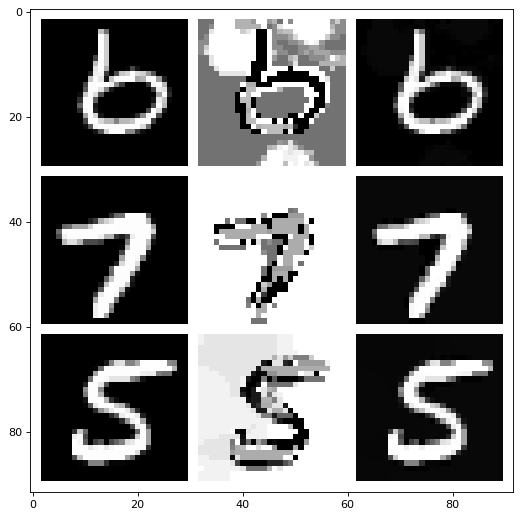

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib
import torchvision
%matplotlib inline

clean_train_dataset_data = clean_train_dataset.data.to('cpu').numpy()

def imshow(img):
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def get_pairs_of_imgs(idx):
    clean_img = clean_train_dataset_data[idx]
    unlearnable_img = unlearnable_train_dataset.data[idx]
    clean_img = torchvision.transforms.functional.to_tensor(clean_img)
    unlearnable_img = torchvision.transforms.functional.to_tensor(unlearnable_img)

    x = noise[idx]
    x_min = torch.min(x)
    x_max = torch.max(x)
    noise_norm = (x - x_min) / (x_max - x_min)
    noise_norm = torch.clamp(noise_norm, 0, 1)
    return [clean_img, noise_norm, unlearnable_img]
    
selected_idx = [random.randint(0, 50000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
    img_grid += get_pairs_of_imgs(idx)
    

imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=3, pad_value=255))



<h3>Train ResNet34 on Unlearnable Dataset</h3>

In [ ]:
from util import AverageMeter
from ResNet import ResNet34
import torch
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm
#from torchvision import datasets, transforms

model = ResNet34()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

unlearnable_train_dataset.data = torch.from_numpy(unlearnable_train_dataset.data)
unlearnable_loader = DataLoader(dataset=unlearnable_train_dataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False, num_workers=2)

unlearnable_acc = []
for epoch in range(10):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    tqdm.write('Clean Accuracy %.2f\n' % (acc*100))
    unlearnable_acc.append(acc*100)
            

Acc 86.62 Loss: 0.43: 100%|██████████| 469/469 [00:48<00:00,  9.68it/s]


Clean Accuracy 9.50



Acc 98.66 Loss: 0.04: 100%|██████████| 469/469 [00:48<00:00,  9.69it/s]


Clean Accuracy 17.60



Acc 98.97 Loss: 0.03: 100%|██████████| 469/469 [00:48<00:00,  9.67it/s]


Clean Accuracy 9.65



Acc 99.11 Loss: 0.03: 100%|██████████| 469/469 [00:48<00:00,  9.65it/s]


Clean Accuracy 10.36



Acc 99.19 Loss: 0.03: 100%|██████████| 469/469 [00:48<00:00,  9.63it/s]


Clean Accuracy 10.47



Acc 99.39 Loss: 0.02: 100%|██████████| 469/469 [00:48<00:00,  9.63it/s]


Clean Accuracy 14.42



Acc 99.43 Loss: 0.02: 100%|██████████| 469/469 [00:48<00:00,  9.63it/s]


Clean Accuracy 17.78



Acc 99.44 Loss: 0.02: 100%|██████████| 469/469 [00:48<00:00,  9.68it/s]


Clean Accuracy 19.41



Acc 99.47 Loss: 0.02: 100%|██████████| 469/469 [00:48<00:00,  9.66it/s]


Clean Accuracy 14.19



Acc 99.39 Loss: 0.02: 100%|██████████| 469/469 [00:48<00:00,  9.64it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f12a0123440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f12a0123440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", lin

Clean Accuracy 10.45



## Train ResNet34 on Original Dataset

In [ ]:
from util import AverageMeter
from ResNet import ResNet34
import torch
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm
#from torchvision import datasets, transforms

model = ResNet34()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

clean_loader = DataLoader(dataset=clean_train_dataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False, num_workers=2)

# clean_accuracy = []
for epoch in range(10):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(clean_loader, total=len(clean_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    tqdm.write('Clean Accuracy %.2f\n' % (acc*100))
    # clean_accuracy.append(acc*100)

Acc 84.30 Loss: 0.51: 100%|██████████| 469/469 [00:48<00:00,  9.67it/s]


Clean Accuracy 93.36



Acc 96.13 Loss: 0.13: 100%|██████████| 469/469 [00:48<00:00,  9.68it/s]


Clean Accuracy 96.18



Acc 97.18 Loss: 0.09: 100%|██████████| 469/469 [00:48<00:00,  9.67it/s]


Clean Accuracy 97.35



Acc 97.54 Loss: 0.08: 100%|██████████| 469/469 [00:48<00:00,  9.66it/s]


Clean Accuracy 97.19



Acc 97.52 Loss: 0.08: 100%|██████████| 469/469 [00:48<00:00,  9.65it/s]


Clean Accuracy 97.49



Acc 97.91 Loss: 0.07: 100%|██████████| 469/469 [00:48<00:00,  9.66it/s]


Clean Accuracy 97.03



Acc 97.88 Loss: 0.07: 100%|██████████| 469/469 [00:48<00:00,  9.66it/s]


Clean Accuracy 98.28



Acc 97.96 Loss: 0.07: 100%|██████████| 469/469 [00:48<00:00,  9.66it/s]


Clean Accuracy 98.09



Acc 98.13 Loss: 0.06: 100%|██████████| 469/469 [00:48<00:00,  9.65it/s]


Clean Accuracy 96.01



Acc 98.16 Loss: 0.06: 100%|██████████| 469/469 [00:48<00:00,  9.63it/s]


Clean Accuracy 97.41



## Manually Collect Data and Plot Accuracy

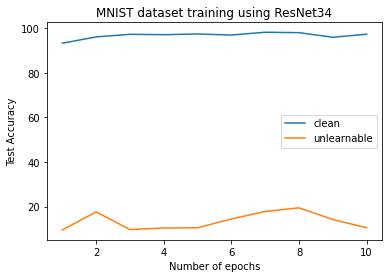

In [ ]:
clean = [93.36, 96.18,97.35, 97.19,97.49,97.03,98.28,98.09,96.01,97.41]
unlearnable = [9.50,17.60,9.65,10.36,10.47,14.42,17.78,19.41,14.19,10.45]
x = [s for s in range(1,11)]
plt.plot(x, clean, x, unlearnable)
plt.legend(["clean", "unlearnable"]);
plt.title("MNIST dataset training using ResNet34");
plt.xlabel("Number of epochs")
plt.ylabel("Test Accuracy");